# Chow's Test: detecting change points

The Chow test, proposed by econometrician Gregory Chow in 1960, is a test of whether the true coefficients in two linear regressions on different data sets are equal. This test is specially useful for identifying change points in a timeseries, when we know the position of the potential breakpoint.

### Imports

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### Functions

For computing the Chow's statistic we need to compute the Sum of Squared Residuals (SSR):

$SSR=\sum_{i=1}^N (y_i - \hat{y}_i)2$

where $y_i$ is the value of the time series at time $i$ and $\hat{y}_i$ is the prediction at time $i$. In this test, the prediction is computed by means of linear regression.

In [2]:
def ssr(y, yhat):
    return np.sum(np.power(yhat-y,2))

Suppose that we can model our time series as $y_t = ax_t + b + \epsilon $, where $a$ is the slope, $b$ is the intercept, $\epsilon$ is normal random noise, and $x_t$ is the time index. 

We can split the data into two segments based on the time index in the following way: $y_{t_1} = a_1x_{t_1} + b_1 + \epsilon $ when $0\leq t_1 \leq t_{cp}$ and $y_{t_2} = a_1x_{t_2} + b_1 + \epsilon $ when $t_{cp} \leq t_2 \leq N$, where $t_{cp}$ is the time index of the change point and $N$ is the length of the timeseries.

What Chow's test tries to asses is if the coefficients of the linear regressions in both segments are the same. This is,
* $H_0$: $a_1=a_2$ and $b_1 = b_2$, there is no changepoint
* $H_A$: there is a changepoint

To perform the test, we fit linear regression models for the three segments: timeseries before changepoint ($y_{before}$), timeseries after changepoint ($y_{after}$), and total timeseries ($y_{total}$). Our goal is to test if we can explain more variance using two models divided by the changepoint or a single model fitting the complete time series. To do so, we compute the Sum of Squared Residuals (SSR) for each of the segments and compute Chow's statistic with the following formula:

$$chow = \frac{(SSR_{total} - (SSR_{before} + SSR_{after}))/k}{((SSR_{before}+SSR_{after})/N- 2k)}$$

where $k$ is the number of parameters of the linear regression model, in our case $k=2$ as we have $a,b$. 

Chow's test statistic follows the F-distribution with $k$ k and $N-2k$ degrees of freedom, so we get the p-value for this distribution. Finally, if our p-value is smaller than our threshold, we can reject the null hypothesis and we conclude that there is a structural break.

In [3]:
def chow_test(y_total, breakpoint, x_total=None, p_value = 0.05):
    # 1. Get segments in the time series before/after breakpoint
    y_before = y_total[:breakpoint] #timeseries before change point
    y_after = y_total[breakpoint:] #timeseries after change point
    
    if x_total is None:
        x_total = np.arange(len(y_total))
    x_before = x_total[:breakpoint] #time index before change point
    x_after = x_total[breakpoint:] #time index after change point
    
    #2. Fit a linear regression for each segment
    a,b = np.polyfit(x_before, y_before, deg=1)
    yhat_before = a*x_before + b # linear regression for before segment
    
    a,b = np.polyfit(x_after, y_after, deg=1)
    yhat_after = a*x_after + b # linear regression for after segment
    
    a,b = np.polyfit(x_total, y_total, deg=1)
    yhat_total = a*x_total+ b # total linear regression
    
    #3. Get the sum of squared errors (ssr) for each segment 
    ssr_before = ssr(y_before, yhat_before)
    ssr_after = ssr(y_after, yhat_after)
    ssr_total = ssr(y_total, yhat_total)
    
    #4. Compute Chow's test statistc
    k1 = 2 # degree of freedom 
    k2 = (len(y_total) - 2*k1)
    numerator = ((ssr_total - (ssr_before + ssr_after)) / k1)
    denominator = ((ssr_before + ssr_after) / k2)
    chow = numerator/denominator
    
    # 5. Perform test
    p = 1-stats.f.cdf(chow, k1, k2) #get p-value from F distribution
    if p < p_value:
        print("Reject the null hypothesis. There is a structural break at time {}".format(x_total[breakpoint]))
        return True
    else:
        print("Accept the null hypothesis. There is no structural break at time {}".format(x_total[breakpoint]))
        return False

### Examples

In [4]:
N = 1000

Accept the null hypothesis. There is no structural break at time 7


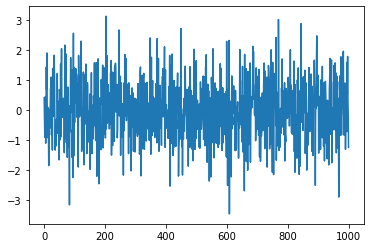

In [5]:
y1 = np.random.normal(0,1,N)
breakpoint = np.random.randint(N)
is_changepoint = chow_test(y1, breakpoint)
plt.plot(y1)
if is_changepoint:
    plt.axvline(breakpoint, color='r', linestyle='--')
plt.show()

Reject the null hypothesis. There is a structural break at time 738


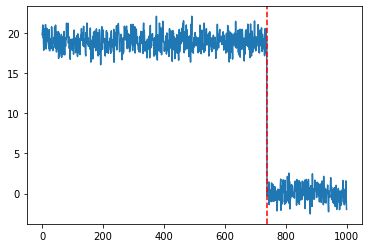

In [6]:
y2 = np.random.normal(0,1,N)
breakpoint = np.random.randint(N)
intercept = np.random.randint(10, 20)
y2[:breakpoint] = y2[:breakpoint]+ intercept
is_changepoint = chow_test(y2, breakpoint)
plt.plot(y2)
if is_changepoint:
    plt.axvline(breakpoint, color='r', linestyle='--')
plt.show()


Accept the null hypothesis. There is no structural break at time 38


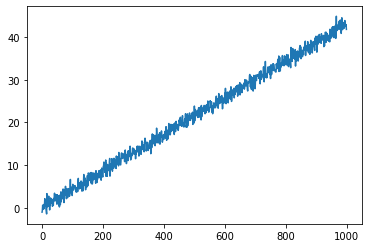

In [7]:
y3 = np.random.normal(0,1,N)
breakpoint = np.random.randint(N)
slope = np.random.uniform(0,1)
y3 = y3 + slope*np.arange(N)
is_changepoint = chow_test(y3, breakpoint)
plt.plot(y3)
if is_changepoint:
    plt.axvline(breakpoint, color='r', linestyle='--')
plt.show()


Reject the null hypothesis. There is a structural break at time 34


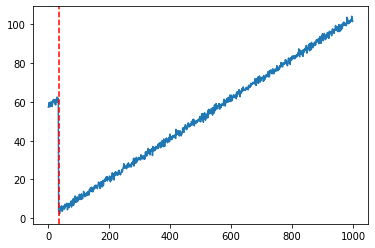

In [8]:
y4 = np.random.normal(0,1,N)
breakpoint = np.random.randint(N)
slope = np.random.uniform(0,1)
intercept = np.random.randint(50, 100)
y4 = y4 + slope*np.arange(N)
y4[:breakpoint] = y4[:breakpoint] + intercept
is_changepoint = chow_test(y4, breakpoint)
plt.plot(y4)
if is_changepoint:
    plt.axvline(breakpoint, color='r', linestyle='--')
plt.show()


Reject the null hypothesis. There is a structural break at time 788


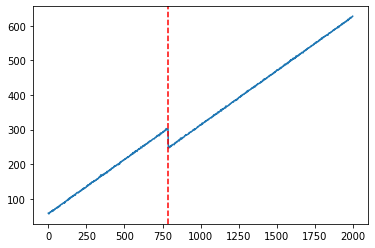

In [9]:
y4 = np.random.normal(0,1,N)
breakpoint = np.random.randint(N)
slope = np.random.uniform(0,1)
intercept = np.random.randint(50, 100)
y4 = y4 + slope*np.arange(N)
y4[:breakpoint] = y4[:breakpoint] + intercept
x4 = np.arange(0, 2*N, 2)
is_changepoint = chow_test(y4, breakpoint, x_total = x4)
plt.plot(x4, y4)
if is_changepoint:
    plt.axvline(x4[breakpoint], color='r', linestyle='--')
plt.show()
